# Librerias

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

# Archivo

In [11]:
# Abrir archivos CSV
mbr = pd.read_csv('archivos_limpios\mbr.csv')

<>:2: DeprecationWarning: invalid escape sequence '\m'
<>:2: DeprecationWarning: invalid escape sequence '\m'
C:\Users\tomas\AppData\Local\Temp\ipykernel_28524\548903745.py:2: DeprecationWarning: invalid escape sequence '\m'
  mbr = pd.read_csv('archivos_limpios\mbr.csv')


#### Crear columnas

In [12]:
# app
# si aparece ".com." nos llevamos lo que viene justo después
pat  = r'(?:^|\.)com\.([^.]+)'          
app_main = mbr['app_package'].str.extract(pat, expand=False)

# si no hay ".com." nos quedamos con la segunda parte de app_package
fallback = mbr['app_package'].str.split('.').str.get(1)

mbr['app'] = app_main.fillna(fallback)

In [13]:
# semanal
mbr["week"] = pd.to_datetime(mbr["formated_date"]).dt.to_period("W")

In [14]:
# Mes
mbr['month'] = pd.to_datetime(mbr['formated_date']).dt.to_period('M')

In [15]:
# 1. Lista de palabras “basura” que no son apps reales
junk = {'app', 'co', 'com'}           # agrega más si hace falta

# 2. Filtra esas filas antes de crear las cestas mensuales
mbr = mbr[~mbr['app'].isin(junk)].copy()

# 3. Vuelve a construir baskets_m y correr Apriori como antes
#    (todo el pipeline se mantiene igual)

#### Info archivo

In [16]:
mbr.head()

,app_package,review,rating,votes,uid,formated_date,app_category,app,week,month
0,com.cleverapps.heroes,It's really a fun game,5,1,shqoc6X1fcJRLEmx,2018-10-21,Casual,cleverapps,2018-10-15/2018-10-21,2018-10
1,com.bodyfast,uninstalling. it was ok but felt like it was c...,2,0,shqoc6X1fcJRLEmx,2019-01-18,Health & Fitness,bodyfast,2019-01-14/2019-01-20,2019-01
2,com.thrivegames.wordshapes,Love this game,4,1,shqoc6X1fcJRLEmx,2021-01-16,Word,thrivegames,2021-01-11/2021-01-17,2021-01
3,com.affinity.rewarded_play,Doesn't update play time. Just downloaded it 3...,1,1,shqoc6X1fcJRLEmx,2021-11-04,Entertainment,affinity,2021-11-01/2021-11-07,2021-11
4,dating.inmessage.net,app crashes every time I try to log in. what g...,1,0,shqoc6X1fcJRLEmx,2021-11-24,Dating,inmessage,2021-11-22/2021-11-28,2021-11


In [17]:
mbr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197749 entries, 0 to 199986
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype        
---  ------         --------------   -----        
 0   app_package    197749 non-null  object       
 1   review         197749 non-null  object       
 2   rating         197749 non-null  int64        
 3   votes          197749 non-null  int64        
 4   uid            197749 non-null  object       
 5   formated_date  197749 non-null  object       
 6   app_category   197749 non-null  object       
 7   app            197749 non-null  object       
 8   week           197749 non-null  period[W-SUN]
 9   month          197749 non-null  period[M]    
dtypes: int64(2), object(6), period[M](1), period[W-SUN](1)
memory usage: 16.6+ MB


# Pregunta 1: ¿Existen combinaciones de apps que se descargan juntas? Ya que si ciertas apps se descargan juntas podemos estar frente a un “ecosistema digital”

Podriamos cambiar de pregunta en vez de que "se descargen juntas" a "descargan en un mismo periodo de tiempo"

## A-priori

Para saber si existen apps que se descargan juntas, probe tres periododds de tiempo: **dia, semana y mes**.

Primero crei que, si un usuario instalaba varias apps “a la vez”, seria **el mismo dia**. Corri Apriori con un `min_support` muy bajo , pero casi todas las cestas diarias tenian solo una app y aparecio un unico par: la descarga simultsnea NO existe.

Entonces ahora con **una semana**. Hay **23** pares: las co-descargas existen, pero son pocas e inestables.

Finalmente probe con **un mes** y si funciono: aparecieron **373** pares con *lift* alto (> 2), señal de “ecosistemas” de apps que se instalan a lo largo del mes. :)


### Por dia

In [18]:
baskets_d = (mbr.groupby(["uid", "formated_date"])["app"]
    .apply(lambda x: sorted(set(x))).tolist())

te = TransactionEncoder()
te_fit = te.fit(baskets_d)
matriz_dia = te_fit.transform(baskets_d, sparse=True)   
df_dia = pd.DataFrame.sparse.from_spmatrix(matriz_dia,columns = te_fit.columns_)

itemsets_d = apriori(df_dia,
    min_support = 0.00001,   # ES MUY CHICO
    use_colnames = True,
    low_memory   = True)   

apriori_dia = (itemsets_d[itemsets_d['itemsets'].str.len() >= 2]
    .sort_values('support', ascending=False))

C:\Users\tomas\AppData\Local\Temp\ipykernel_28524\3448599442.py:7: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_dia = pd.DataFrame.sparse.from_spmatrix(matriz_dia,columns = te_fit.columns_)


In [19]:
print("Encontrados:", len(apriori_dia))
display(apriori_dia.head())

Encontrados: 1


,support,itemsets
4586,0.00001,"(experian, facebook)"


### Por semana

In [ ]:
baskets_s = (mbr.groupby(["uid", "week"])["app"]
    .apply(lambda x: sorted(set(x))).tolist())

te = TransactionEncoder()
matriz_semana = te.fit_transform(baskets_s, sparse=True)
df_semana = pd.DataFrame.sparse.from_spmatrix(matriz_semana, columns=te.columns_)

itemsets_s = apriori(df_semana,
    min_support = 0.00001,   
    use_colnames= True,
    low_memory  = True)

apriori_semana = (itemsets_s[itemsets_s['itemsets'].str.len() >= 2]
    .sort_values('support', ascending=False))

C:\Users\tomas\AppData\Local\Temp\ipykernel_28524\2108801526.py:6: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_semana = pd.DataFrame.sparse.from_spmatrix(matriz_semana, columns=te.columns_)


In [21]:
print("Encontrados:", len(apriori_semana))
display(apriori_semana.head())

Encontrados: 23


,support,itemsets
4597,0.000016,"(google, g5e)"
4602,0.000016,"(my, google)"
4586,0.000010,"(microsoft, CarXTech)"
4589,0.000010,"(huawei, amazon)"
4590,0.000010,"(blackpanther, microsoft)"


### Por mes

In [22]:
baskets_m = (mbr.groupby(['uid', 'month'])['app']
    .apply(lambda x: sorted(set(x))).tolist())

te  = TransactionEncoder()
matriz_mes = te.fit_transform(baskets_m, sparse=True)
df_mes = pd.DataFrame.sparse.from_spmatrix(matriz_mes, columns=te.columns_)

itemsets_m = apriori(df_mes,
    min_support=0.00001,
    max_len=2,
    use_colnames=True,
    low_memory=True)

apriori_mes = (itemsets_m[itemsets_m['itemsets'].str.len() >= 2]
    .sort_values('support', ascending=False))

C:\Users\tomas\AppData\Local\Temp\ipykernel_28524\1750660222.py:6: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df_mes = pd.DataFrame.sparse.from_spmatrix(matriz_mes, columns=te.columns_)


In [23]:
print("Encontrados:", len(apriori_mes))
display(apriori_mes.head())

Encontrados: 376


,support,itemsets
4810,0.000039,"(playrix, google)"
4789,0.000039,"(microsoft, google)"
4713,0.000028,"(google, etsy)"
4731,0.000028,"(google, fungames)"
4735,0.000028,"(google, g5e)"


### Graficos

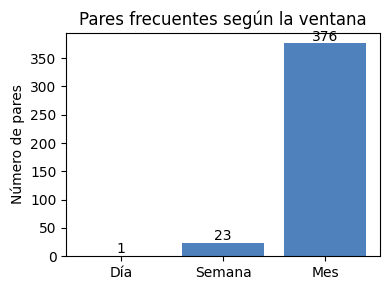

In [ ]:
n_pares_dia = len(apriori_dia)          
n_pares_sem = len(apriori_semana)      
n_pares_mes = len(apriori_mes)

ventanas = ['Día', 'Semana', 'Mes']
n_pares  = [n_pares_dia, n_pares_sem, n_pares_mes]

plt.figure(figsize=(4,3))
plt.bar(ventanas, n_pares, color='#4F81BD')
for x, y in zip(ventanas, n_pares):
    plt.text(x, y+5, y, ha='center', fontsize=10)
plt.ylabel('Número de pares')
plt.title('Pares frecuentes según la ventana')
plt.tight_layout()
plt.show()

In [63]:
rules_m = association_rules(itemsets_m, metric="lift", min_threshold=0)

rules_m['ant_len']  = rules_m['antecedents'].apply(len)
rules_m['cons_len'] = rules_m['consequents'].apply(len)
rules_1to1 = rules_m.query("ant_len == 1 and cons_len == 1").copy()

def make_pair_label(row):
    a = next(iter(row['antecedents']))
    b = next(iter(row['consequents']))
    return " ⟷ ".join(sorted([a, b]))

rules_1to1['pair'] = rules_1to1.apply(make_pair_label, axis=1)

unique_pairs = (
    rules_1to1
    .drop_duplicates('pair')
    [['pair', 'support', 'lift']]
)

top = (
    unique_pairs.sort_values('lift', ascending=False) .reset_index(drop=True) )
top.head()


,pair,support,lift
0,cscmobi ⟷ wendys,0.000011,481.271277
1,amrita ⟷ grove,0.000011,344.681905
2,BlueShark ⟷ tritonesoft,0.000011,231.404092
3,flightradar24free ⟷ wildlifestudios,0.000011,133.894192
4,KisekiGames ⟷ rolling,0.000011,127.659965


## Redes Bayesianas 
No es necesario
